In [2]:
!pip install tensorflow
!pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 74.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 105.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 113.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 117.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 18.8 MB/s eta 0:00:00


In [3]:
import os
import zipfile
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
import numpy as np
from skimage import feature
from collections import Counter
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import LSTM, Reshape, GlobalAveragePooling2D

In [4]:
# First, unzip the archive if it's a zip file
def unzip_dataset(zip_path):
    # Check if the path is a zip file
    if zip_path.endswith('.zip'):
        # Create a directory with the same name as the zip file (without .zip)
        extract_path = zip_path.replace('.zip', '')

        # Unzip the file if the extraction directory doesn't exist
        if not os.path.exists(extract_path):
            with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                zip_ref.extractall(extract_path)

        return extract_path
    else:
        # If it's not a zip file, assume it's already an extracted directory
        return zip_path

# Update the data directory path
data_dir = unzip_dataset("/content/archive.zip")
categories = ["no", "yes"]

# Count images in each category
category_counts = {category: len(os.listdir(os.path.join(data_dir, category))) for category in categories}
print("Dataset Summary:", category_counts)

Dataset Summary: {'no': 98, 'yes': 155}


In [5]:
print("Path of unzipped data folder:", data_dir)

Path of unzipped data folder: /content/archive


<ipython-input-6-d146daba7be4>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(category_counts.keys()), y=list(category_counts.values()), palette="coolwarm")


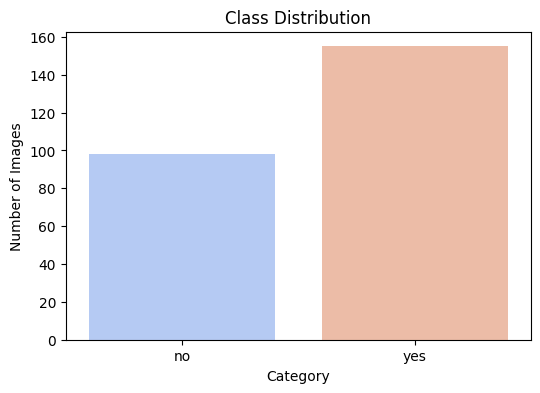

In [6]:
# Visualize class distribution
plt.figure(figsize=(6, 4))
sns.barplot(x=list(category_counts.keys()), y=list(category_counts.values()), palette="coolwarm")
plt.title("Class Distribution")
plt.xlabel("Category")
plt.ylabel("Number of Images")
plt.show()

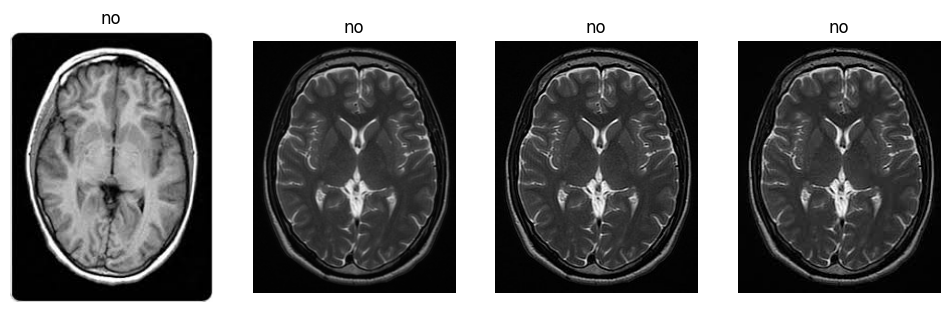

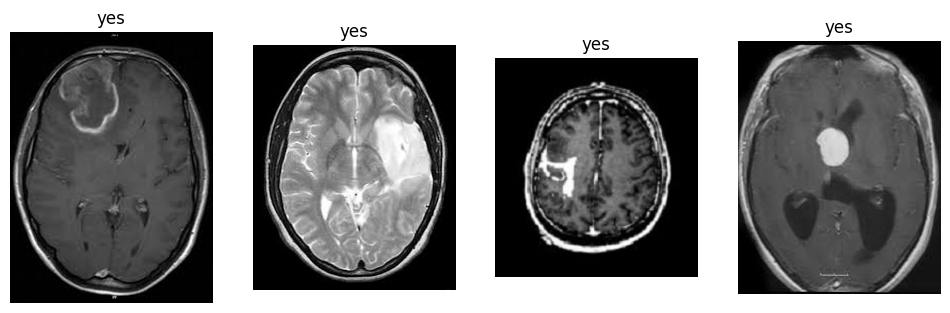

In [7]:
# Display sample images
def display_sample_images(category, num_samples=4):
    category_path = os.path.join(data_dir, category)
    images = os.listdir(category_path)[:num_samples]

    fig, axes = plt.subplots(1, num_samples, figsize=(12, 4))
    for i, img_name in enumerate(images):
        img = cv2.imread(os.path.join(category_path, img_name))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[i].imshow(img)
        axes[i].axis("off")
        axes[i].set_title(category)
    plt.show()

# Show sample images from both categories
for category in categories:
    display_sample_images(category)

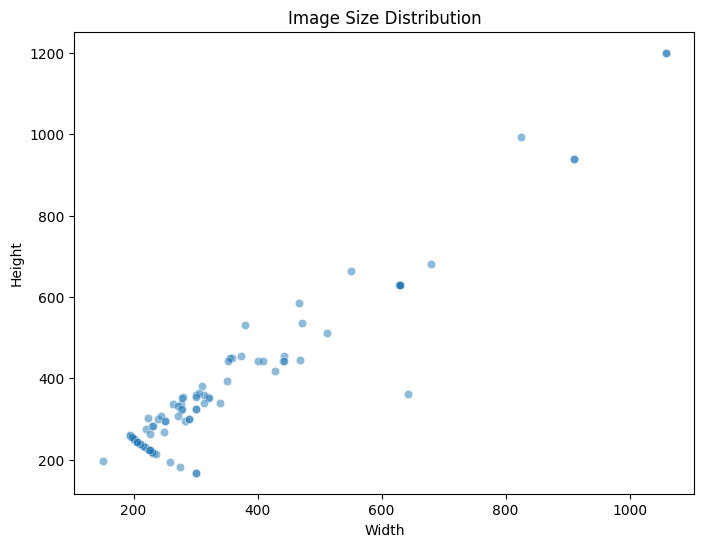

In [8]:
# Image size analysis
image_shapes = []
for category in categories:
    category_path = os.path.join(data_dir, category)
    images = os.listdir(category_path)[:50]  # Sampling 50 images per category
    for img_name in images:
        img = cv2.imread(os.path.join(category_path, img_name))
        if img is not None:
            image_shapes.append(img.shape[:2])  # Store (height, width)

# Convert to numpy array for analysis
image_shapes = np.array(image_shapes)

# Plot image size distribution
plt.figure(figsize=(8, 6))
sns.scatterplot(x=image_shapes[:, 1], y=image_shapes[:, 0], alpha=0.5)
plt.xlabel("Width")
plt.ylabel("Height")
plt.title("Image Size Distribution")
plt.show()

Unique Image Sizes: Counter({(np.int64(225), np.int64(225)): 9, (np.int64(251), np.int64(201)): 4, (np.int64(630), np.int64(630)): 4, (np.int64(168), np.int64(300)): 2, (np.int64(231), np.int64(218)): 2, (np.int64(217), np.int64(232)): 2, (np.int64(244), np.int64(206)): 2, (np.int64(294), np.int64(250)): 2, (np.int64(938), np.int64(911)): 2, (np.int64(1200), np.int64(1059)): 2, (np.int64(325), np.int64(300)): 2, (np.int64(300), np.int64(289)): 2, (np.int64(259), np.int64(194)): 1, (np.int64(449), np.int64(359)): 1, (np.int64(275), np.int64(220)): 1, (np.int64(250), np.int64(201)): 1, (np.int64(198), np.int64(150)): 1, (np.int64(338), np.int64(276)): 1, (np.int64(221), np.int64(228)): 1, (np.int64(417), np.int64(428)): 1, (np.int64(257), np.int64(196)): 1, (np.int64(444), np.int64(468)): 1, (np.int64(454), np.int64(442)): 1, (np.int64(393), np.int64(350)): 1, (np.int64(361), np.int64(642)): 1, (np.int64(194), np.int64(259)): 1, (np.int64(537), np.int64(472)): 1, (np.int64(442), np.int64

<ipython-input-9-abe7d6a07594>:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(color_counts.keys()), y=list(color_counts.values()), palette="viridis")


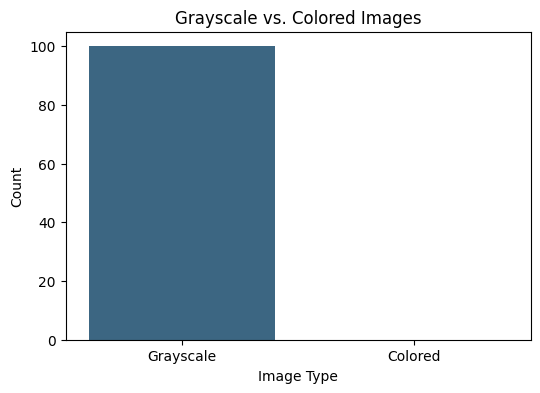

In [9]:
# Additional Insights
# 1. Checking unique image sizes
unique_sizes = Counter(map(tuple, image_shapes))
print("Unique Image Sizes:", unique_sizes)

# 2. Average Image Dimensions
avg_height = np.mean(image_shapes[:, 0])
avg_width = np.mean(image_shapes[:, 1])
print(f"Average Image Dimensions: {avg_width:.2f} x {avg_height:.2f}")

# 3. Checking grayscale vs. colored images
color_counts = {"Grayscale": 0, "Colored": 0}
for category in categories:
    category_path = os.path.join(data_dir, category)
    images = os.listdir(category_path)[:50]
    for img_name in images:
        img = cv2.imread(os.path.join(category_path, img_name))
        if img is not None:
            if len(img.shape) == 3 and img.shape[2] == 3:
                color_counts["Grayscale"] += 1
            else:
                color_counts["Colored"] += 1

# Plot grayscale vs. colored distribution
plt.figure(figsize=(6, 4))
sns.barplot(x=list(color_counts.keys()), y=list(color_counts.values()), palette="viridis")
plt.title("Grayscale vs. Colored Images")
plt.xlabel("Image Type")
plt.ylabel("Count")
plt.show()

/usr/local/lib/python3.11/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


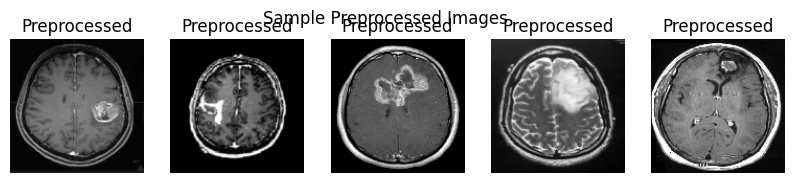

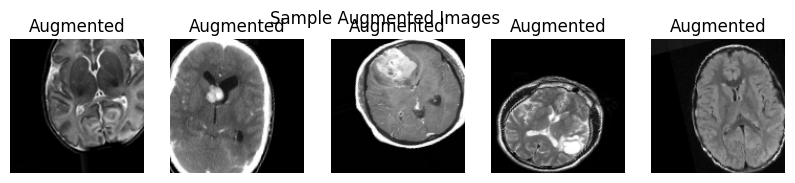

Preprocessed and augmented dataset loaded: 253 samples.
Train: (182, 128, 128, 3), Val: (20, 128, 128, 3), Test: (51, 128, 128, 3)


In [10]:

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define constants
img_size = (128, 128)
categories = ["no", "yes"]
data_dir = "/content/archive"

# Feature extraction: Local Binary Pattern
def extract_lbp_features(gray_img):
    lbp = local_binary_pattern(gray_img, P=8, R=1, method='uniform')
    lbp = (lbp - lbp.min()) / (lbp.max() - lbp.min())  # Normalize
    return lbp

# Segmentation using Otsu Threshold
def segment_image(gray_img):
    thresh = threshold_otsu(gray_img)
    binary_mask = gray_img > thresh
    return binary_mask.astype(np.float32)


# Enhanced image loader with preprocessing
def load_and_preprocess_images(category):
     category_path = os.path.join(data_dir, category)
     images = []
     labels = []
     label = 0 if category == "no" else 1

     for img_name in os.listdir(category_path):
        img_path = os.path.join(category_path, img_name)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, img_size)
            gray = rgb2gray(img)
            segmented = segment_image(gray)
            lbp = extract_lbp_features(gray)

            # Stack original + segmented + LBP as channels
            processed_img = np.stack([gray, segmented, lbp], axis=-1)
            images.append(processed_img)
            labels.append(label)

     return np.array(images), np.array(labels)


# Load data with full preprocessing
x_no, y_no = load_and_preprocess_images("no")
x_yes, y_yes = load_and_preprocess_images("yes")

# Merge and split
X = np.concatenate((x_no, x_yes), axis=0)
y = np.concatenate((y_no, y_yes), axis=0)

from sklearn.model_selection import train_test_split

# First split off the training data (72%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.28, stratify=y, random_state=42)
# Then split remaining 28% into 20% test and 8% validation
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=20/28, stratify=y_temp, random_state=42)

# Data augmentation
augmentor = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Fit the generator on training data
augmentor.fit(X_train)

# Show 5 preprocessed images
plt.figure(figsize=(10, 2))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(X_train[i][:,:,0], cmap='gray')
    plt.title("Preprocessed")
    plt.axis('off')
plt.suptitle("Sample Preprocessed Images")
plt.show()

# Show 5 augmented images
aug_iter = augmentor.flow(X_train, y_train, batch_size=5)
augmented_imgs, _ = next(aug_iter)

plt.figure(figsize=(10, 2))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(augmented_imgs[i][:,:,0], cmap='gray')
    plt.title("Augmented")
    plt.axis('off')
plt.suptitle("Sample Augmented Images")
plt.show()

print(f"Preprocessed and augmented dataset loaded: {X.shape[0]} samples.")
print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")


## **CNN Model**

In [11]:
#Feature enhancement
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
img_eq = cv2.equalizeHist(img_gray)  # Apply histogram equalization

#Edge detection
edges = cv2.Canny(img_gray, 50, 150)  # Use grayscale image for edge detection

In [12]:
from tensorflow import keras
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential([
    # Input layer
    keras.Input(shape=(128, 128, 3)),

    # Convolutional layers with regularization
    Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=keras.regularizers.l2(0.01)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=keras.regularizers.l2(0.01)),
    MaxPooling2D((2, 2)),

    # Flatten for dense layers
    Flatten(),

    # Dense layers with regularization
    Dense(64, activation='relu',kernel_regularizer=keras.regularizers.l2(0.01)),
    Dropout(0.5),
    Dense(1, activation='sigmoid') # Output layer
])

# --- Model Compilation and Training ---

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), callbacks=[early_stopping])


# --- Evaluation ---

test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 846ms/step - accuracy: 0.5928 - loss: 3.7583 - val_accuracy: 0.6000 - val_loss: 1.8690
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 743ms/step - accuracy: 0.5832 - loss: 1.8913 - val_accuracy: 0.7000 - val_loss: 1.6892
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 688ms/step - accuracy: 0.6278 - loss: 1.6551 - val_accuracy: 0.8500 - val_loss: 1.5114
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 688ms/step - accuracy: 0.7592 - loss: 1.4649 - val_accuracy: 0.7500 - val_loss: 1.3593
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 687ms/step - accuracy: 0.8009 - loss: 1.2932 - val_accuracy: 0.7500 - val_loss: 1.3139
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 688ms/step - accuracy: 0.7624 - loss: 1.2593 - val_accuracy: 0.9000 - val_loss: 1.2151
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 688ms/step - accuracy: 0.7883 - loss: 1.1874 - val_accuracy: 0.9000 - val_loss: 1.1377
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 705ms/step - accuracy: 0.8362 - loss: 1.0731 - val_accuracy: 0.9000 - val_loss:

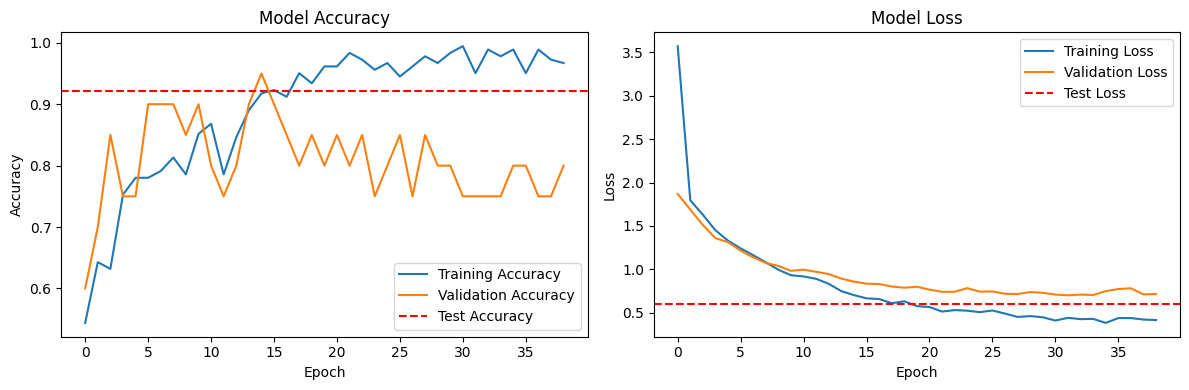

In [13]:
# Plot Accuracy and Loss
plt.figure(figsize=(12, 4))  # Adjust figure size if needed

# Accuracy plot
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.axhline(y=test_accuracy, color='r', linestyle='--', label='Test Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

# Loss plot
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second plot
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')  # Add test loss line
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


/usr/local/lib/python3.11/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


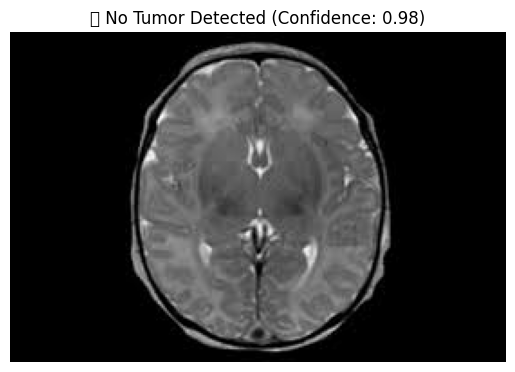

('✅ No Tumor Detected', np.float32(0.98288643))

In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage.feature import local_binary_pattern
from skimage.filters import threshold_otsu

def preprocess_image_for_cnn(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (128, 128))
    gray = rgb2gray(img)

    # Segmentation (Otsu)
    thresh = threshold_otsu(gray)
    segmented = (gray > thresh).astype(np.float32)

    # LBP
    lbp = local_binary_pattern(gray, P=8, R=1, method='uniform')
    lbp = (lbp - lbp.min()) / (lbp.max() - lbp.min())

    # Stack into 3 channels (same as training)
    stacked = np.stack([gray, segmented, lbp], axis=-1)
    stacked = np.expand_dims(stacked, axis=0)  # Add batch dimension
    return stacked

def predict_uploaded_image(img_path):
    processed_img = preprocess_image_for_cnn(img_path)
    prediction = model.predict(processed_img)[0][0]
    label = "🧠 Tumor Detected" if prediction > 0.5 else "✅ No Tumor Detected"
    confidence = prediction if prediction > 0.5 else 1 - prediction

    # Show image and result
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title(f"{label} (Confidence: {confidence:.2f})")
    plt.axis('off')
    plt.show()

    return label, confidence

# --- Run this to test your model on a new image ---
# Replace with the correct file path
# test_image_path = "/content/archive/yes/Y101.jpg"
test_image_path = "/content/archive/no/12 no.jpg"
predict_uploaded_image(test_image_path)


## **RESNET50**

In [15]:
from tensorflow import keras
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 1. Load ResNet50 and Add Custom Layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

num_classes = 2
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.02))(x)  # Increased L2 regularization
x = Dropout(0.7)(x)  # Increased dropout rate
predictions = Dense(num_classes, activation='softmax')(x)

supervised_model = Model(inputs=base_model.input, outputs=predictions)

# 2. Freeze and Fine-tune (Gradual Unfreezing)
for layer in base_model.layers[:175]:  # Freeze more layers initially
    layer.trainable = False

# 3. Compile and Train with Early Stopping and Regularization (Stage 1)
supervised_model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss='sparse_categorical_crossentropy',  # Changed from categorical_crossentropy
    metrics=['accuracy']
)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = supervised_model.fit(
    X_train, y_train,
    epochs=20,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)

# 4. Unfreeze More Layers and Train (Stage 2)
for layer in base_model.layers[140:]:  # Corrected unfreezing range
    layer.trainable = True

supervised_model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Even lower learning rate
    loss='sparse_categorical_crossentropy',  # Keep consistent with stage 1
    metrics=['accuracy']
)

history = supervised_model.fit(
    X_train, y_train,
    epochs=10,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)

# 5. Evaluate the Model
test_loss, test_accuracy = supervised_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# 6. Data Augmentation using ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(X_train)

# 7. Train with Augmented Data
history = supervised_model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    epochs=20,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)

# Evaluate the model on the test data
test_loss, test_accuracy = supervised_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss after Data Augmentation: {test_loss:.4f}")
print(f"Test Accuracy after Data Augmentation: {test_accuracy:.4f}")


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - accuracy: 0.4942 - loss: 5.8207 - val_accuracy: 0.4000 - val_loss: 5.4866
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.3958 - loss: 5.6645 - val_accuracy: 0.4000 - val_loss: 5.2515
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.4867 - loss: 5.3637 - val_accuracy: 0.4000 - val_loss: 5.0558
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.4234 - loss: 5.2519 - val_accuracy: 0.6000 - val_loss: 4.8859
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.5237 - loss: 4.9697 - val_accuracy: 0.6000 - val_loss: 4.7348
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.5230 - loss: 4.8672 - val_accuracy: 0.6000 - val_loss: 4.5971
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.5343 - loss: 4.7517 - val_accuracy: 0.6000 - val_loss: 4.4656
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.5653 - loss: 4.5238

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 24s 4s/step - accuracy: 0.6527 - loss: 3.0007 - val_accuracy: 0.6000 - val_loss: 3.0406
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 24s 4s/step - accuracy: 0.6069 - loss: 3.0431 - val_accuracy: 0.6000 - val_loss: 3.0353
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 23s 4s/step - accuracy: 0.6048 - loss: 3.0706 - val_accuracy: 0.6000 - val_loss: 3.0308
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 23s 4s/step - accuracy: 0.6032 - loss: 3.0293 - val_accuracy: 0.6000 - val_loss: 3.0273
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 24s 4s/step - accuracy: 0.7197 - loss: 2.9467 - val_accuracy: 0.6000 - val_loss: 3.0238
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 23s 4s/step - accuracy: 0.6570 - loss: 2.9451 - val_accuracy: 0.6000 - val_loss: 3.0188
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 24s 4s/step - accuracy: 0.6455 - loss: 3.0157 - val_accuracy: 0.6000 - val_loss: 3.0122
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 24s 4s/step - accuracy: 0.6581 - loss: 2.9672 - val_accuracy: 0.6000 - val_loss: 3.0061
Epoch 9/

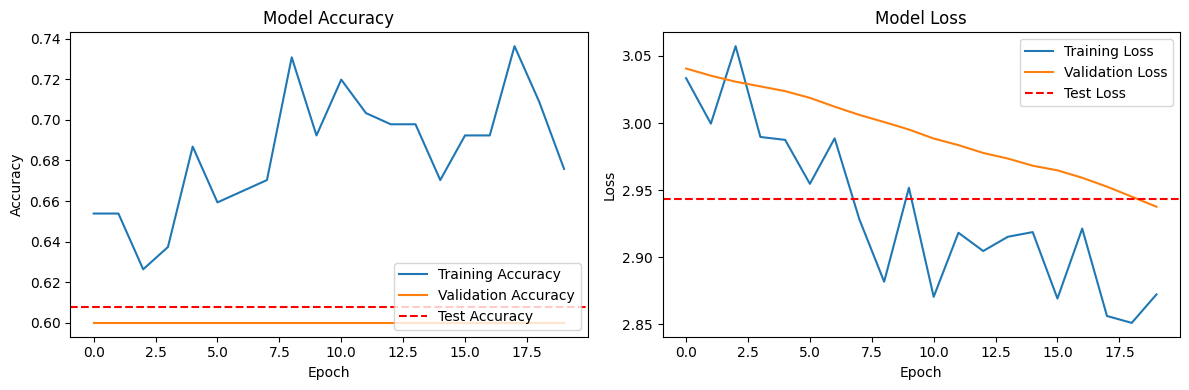

In [16]:
# Plot Accuracy and Loss
plt.figure(figsize=(12, 4))  # Adjust figure size if needed

# Accuracy plot
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.axhline(y=test_accuracy, color='r', linestyle='--', label='Test Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

# Loss plot
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second plot
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')  # Add test loss line
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


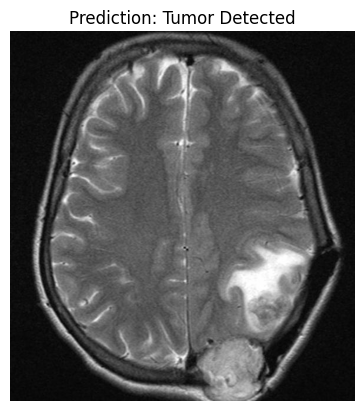

'Tumor Detected'

In [22]:
import cv2
from skimage.feature import local_binary_pattern
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing import image

# --- Prediction Helper Functions ---

def preprocess_image_for_prediction(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (128, 128))
    gray = rgb2gray(img)

    # Segmentation
    thresh = threshold_otsu(gray)
    segmented = (gray > thresh).astype(np.float32)

    # LBP
    lbp = local_binary_pattern(gray, P=8, R=1, method='uniform')
    lbp = (lbp - lbp.min()) / (lbp.max() - lbp.min())  # Normalize

    # Stack as 3 channels
    stacked = np.stack([gray, segmented, lbp], axis=-1)

    # Expand dims for batch shape
    stacked = np.expand_dims(stacked, axis=0)
    return stacked

def predict_brain_tumor(img_path):
    processed_img = preprocess_image_for_prediction(img_path)
    prediction = supervised_model.predict(processed_img)
    class_idx = np.argmax(prediction)
    label = "No Tumor" if class_idx == 0 else "Tumor Detected"

    # Display
    plt.imshow(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB))
    plt.title(f"Prediction: {label}")
    plt.axis("off")
    plt.show()

    return label

# --- Run Prediction ---
# Replace with your actual image path
# uploaded_image_path = "/content/brainmriimage.png"
# uploaded_image_path = "/content/archive/no/10 no.jpg"
uploaded_image_path ="/content/archive/yes/Y102.jpg"
predict_brain_tumor(uploaded_image_path)


## **EfficientNetB3**

In [23]:
# Step 2: Define paths for categories
data_dir = "/content/archive"

no_category_path = os.path.join(data_dir, 'no')
yes_category_path = os.path.join(data_dir, 'yes')

In [24]:
# Step 3: Feature extraction (LBP) and segmentation using Otsu Threshold
def extract_lbp_features(gray_img):
    lbp = local_binary_pattern(gray_img, P=8, R=1, method='uniform')
    lbp = (lbp - lbp.min()) / (lbp.max() - lbp.min())  # Normalize
    return lbp

def segment_image(gray_img):
    thresh = threshold_otsu(gray_img)
    binary_mask = gray_img > thresh
    return binary_mask.astype(np.float32)

In [25]:
# Step 4: Image Preprocessing (RGB-only)
def load_and_preprocess_images_rgb(category_path, label):
    images = []
    labels = []

    for img_name in os.listdir(category_path):
        img_path = os.path.join(category_path, img_name)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
            img = cv2.resize(img, (300, 300))  # Resize to EfficientNetB3 input size
            processed_img = img
            images.append(processed_img)
            labels.append(label)

    return np.array(images), np.array(labels)

In [26]:
# Step 5: Load data for both categories
x_no, y_no = load_and_preprocess_images_rgb(no_category_path, label=0)  # "No" category
x_yes, y_yes = load_and_preprocess_images_rgb(yes_category_path, label=1)  # "Yes" category

In [27]:
# Step 6: Merge both categories into one dataset
X = np.concatenate((x_no, x_yes), axis=0)
y = np.concatenate((y_no, y_yes), axis=0)

In [28]:
from sklearn.model_selection import StratifiedShuffleSplit
import pandas as pd

# 7: Stratified Shuffle Split (72% train, 8% validation, 20% test)
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, temp_index in sss.split(X, y):
    X_train, X_temp = X[train_index], X[temp_index]
    y_train, y_temp = y[train_index], y[temp_index]

sss_val = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
for val_index, test_index in sss_val.split(X_temp, y_temp):
    X_val, X_test = X_temp[val_index], X_temp[test_index]
    y_val, y_test = y_temp[val_index], y_temp[test_index]

# Check class distribution in splits
print(f"Train class distribution:\n{pd.Series(y_train).value_counts()}")
print(f"Validation class distribution:\n{pd.Series(y_val).value_counts()}")
print(f"Test class distribution:\n{pd.Series(y_test).value_counts()}")

Train class distribution:
1    124
0     78
Name: count, dtype: int64
Validation class distribution:
1    15
0    10
Name: count, dtype: int64
Test class distribution:
1    16
0    10
Name: count, dtype: int64


In [29]:
from sklearn.utils import class_weight

# Step 8: Compute class weights to address class imbalance
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

# Check the computed class weights
print("Class Weights:", class_weights)

Class Weights: {0: np.float64(1.294871794871795), 1: np.float64(0.8145161290322581)}


In [30]:
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB3

# Step 9: Define EfficientNetB3 Model
input_layer = Input(shape=(300, 300, 3))  # Input shape for RGB images
base_model = EfficientNetB3(weights='imagenet', include_top=False, input_tensor=input_layer)
base_model.trainable = False  # Freeze the base model initially

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [31]:
# Add custom classifier on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

In [32]:
# Create the final model
model = Model(inputs=input_layer, outputs=predictions)

In [33]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 300, 300,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 300, 300,  │          0 │ input_layer_2[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 300, 300,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 300, 300,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 301, 301,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 150, 150,  │      1,080 │ stem_conv_pad[0]… │
│                     │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 150, 150,  │        160 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 150, 150,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 150, 150,  │        360 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 150, 150,  │        160 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 150, 150,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 40)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 40)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 10)  │        410 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 40)  │        440 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 150, 150,  │          0 │ block1a_activati… │
│ (Multiply)          │ 40)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 150, 150,  │        960 │ block1a_se_excit

 Total params: 10,980,400 (41.89 MB)

 Trainable params: 196,865 (769.00 KB)

 Non-trainable params: 10,783,535 (41.14 MB)

In [34]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

In [35]:
# Step 10: Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [36]:
# Step 11: Train the model (first stage: freeze the base model)
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    class_weight=class_weights,  # Add class weights
    callbacks=[early_stopping]
)

Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 99s 12s/step - accuracy: 0.5053 - loss: 0.7002 - val_accuracy: 0.5600 - val_loss: 0.6817
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 78s 11s/step - accuracy: 0.5603 - loss: 0.6805 - val_accuracy: 0.6800 - val_loss: 0.6396
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 78s 11s/step - accuracy: 0.6712 - loss: 0.6216 - val_accuracy: 0.6800 - val_loss: 0.6182
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 79s 11s/step - accuracy: 0.6554 - loss: 0.6132 - val_accuracy: 0.7600 - val_loss: 0.5779
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 78s 11s/step - accuracy: 0.7690 - loss: 0.5329 - val_accuracy: 0.7200 - val_loss: 0.5495
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 79s 11s/step - accuracy: 0.7149 - loss: 0.5483 - val_accuracy: 0.7600 - val_loss: 0.5314
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 78s 11s/step - accuracy: 0.7702 - loss: 0.5156 - val_accuracy: 0.7600 - val_loss: 0.5135
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 79s 11s/step - accuracy: 0.7765 - loss: 0.4791 - val_accuracy: 0.7600 - val_loss: 0.4961


In [37]:
# Step 13: Plot loss and accuracy curves for training and validation
def plot_loss(history):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_accuracy(history):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

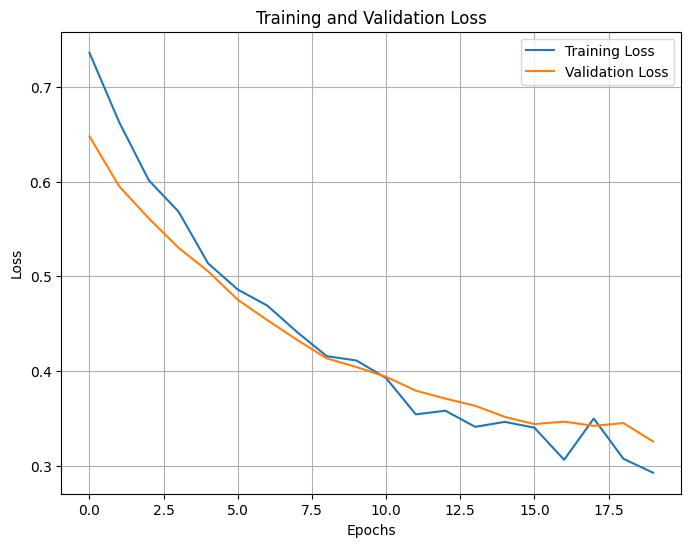

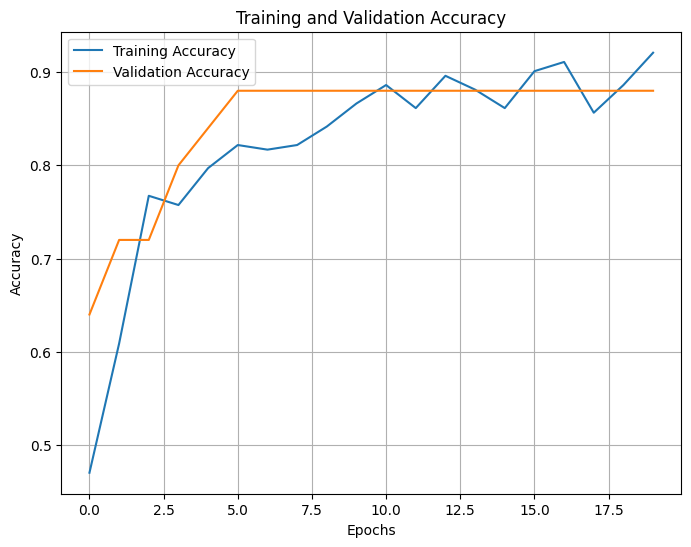

In [35]:
plot_loss(history)  # Plot loss curve for the first training phase
plot_accuracy(history)  # Plot accuracy curve for the first training phase

In [38]:
# Step 14: Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"EfficientNetB3 Test Accuracy: {test_accuracy:.4f}")

EfficientNetB3 Test Accuracy: 0.8462


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step


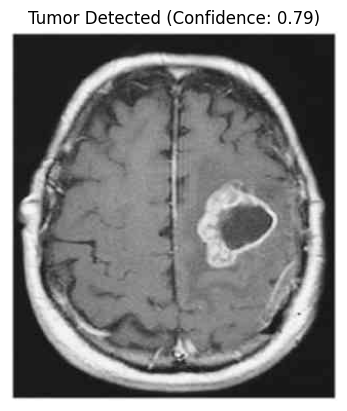

'Tumor Detected'

In [40]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.efficientnet import preprocess_input

# --- Prediction Helper Functions ---

def preprocess_image_for_efficientnet(img_path):
    """
    Preprocess the image for EfficientNetB3 model.
    - Resize to 300x300 (EfficientNetB3 input size).
    - Normalize using preprocess_input from EfficientNet.
    """
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (300, 300))
    img = preprocess_input(img)  # Normalize the image
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

def predict_with_efficientnet(img_path):
    """
    Predict the class of the image using the EfficientNetB3 model.
    - Displays the image along with the prediction and confidence score.
    """
    processed_img = preprocess_image_for_efficientnet(img_path)
    prediction = model.predict(processed_img)[0][0]
    label = "Tumor Detected" if prediction > 0.5 else "No Tumor"
    confidence = prediction if prediction > 0.5 else 1 - prediction

    # Display the image and prediction
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title(f"{label} (Confidence: {confidence:.2f})")
    plt.axis("off")
    plt.show()

    return label

# --- Run Prediction ---
# Replace with your actual image path
# uploaded_image_path = "/content/archive/no/14 no.jpg"
uploaded_image_path = "/content/archive/yes/Y10.jpg"
predict_with_efficientnet(uploaded_image_path)